In [1]:
#pip install pyodbc
#pip install sqlalchemy
#pip install pandas
#pip install networkx
#pip install node2vec

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier

c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
user = 'admin'
password = 'admin'
host = 'localhost\\SQLEXPRESS'
database = 'WideWorldImporters'

engine = create_engine(
    f'mssql+pyodbc://{user}:{password}@{host}/{database}?TrustServerCertificate=yes&driver=ODBC+Driver+17+for+SQL+Server'
)

In [3]:
tdeps = pd.read_sql("""
    SELECT [source] = baseTable.name,
           [source_schema] = schema_name(baseTable.schema_id),
           [target] = refdTable.name,
           [target_schema] = schema_name(refdTable.schema_id),
           [link] = baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name,
           [qry] = 'select link=''' + baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name + ''',source=''' + baseTable.name + ''',source_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + '), ' +
                              'target=''' + refdTable.name + ''',target_count= (select count(1) from '+ schema_name(refdTable.schema_id) + '.' + refdTable.name + '), ' +
                              'fk_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + ' where ' + baseCol.name + ' is not null)'
      FROM [sys].[foreign_key_columns] fkc
      OUTER APPLY (SELECT * FROM sys.tables o WHERE o.object_id = fkc.[parent_object_id]) baseTable
      OUTER APPLY (SELECT * FROM sys.columns o WHERE o.object_id = fkc.[parent_object_id] AND o.column_id = fkc.parent_column_id) baseCol
      OUTER APPLY (SELECT * FROM sys.tables o WHERE o.object_id = fkc.[referenced_object_id]) refdTable
      OUTER APPLY (SELECT * FROM sys.columns o WHERE o.object_id = fkc.[referenced_object_id] AND o.column_id = fkc.referenced_column_id) refdCol
""", engine)

In [4]:
table_names_df = pd.read_csv(r"C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\tables_and_schemas_wwi.csv")

In [5]:
G = nx.from_pandas_edgelist(tdeps, source="source", target="target")

In [6]:
def random_walk_clustering(G, num_clusters=5, 
                           dimensions=64, 
                           walk_length=3, 
                           num_walks=1000, 
                           workers=10):
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

    model = node2vec.fit(window=10, 
                         min_count=1, 
                         batch_words=4)
    
    embeddings = [model.wv[str(node)] for node in G.nodes()]
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    cluster_labels = kmeans.fit_predict(embeddings)

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=42)
    gbc.fit(embeddings, cluster_labels)

    cluster_labels = gbc.predict(embeddings)

    return cluster_labels

In [7]:
num_clusters = 4
cluster_labels = random_walk_clustering(G, num_clusters=num_clusters)

Computing transition probabilities: 100%|██████████| 29/29 [00:00<00:00, 2836.77it/s]
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [8]:
def visualize_clusters(G, cluster_labels, title, ax):
    pos = nx.spring_layout(G)
    num_clusters = len(set(cluster_labels))
    cmap = plt.cm.get_cmap('viridis', num_clusters)
    node_colors = [cmap(label) for label in cluster_labels]
    nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=8, font_weight='bold', ax=ax)
    ax.set_title(title)

C:\Users\tadas\AppData\Local\Temp\ipykernel_15528\1097278861.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


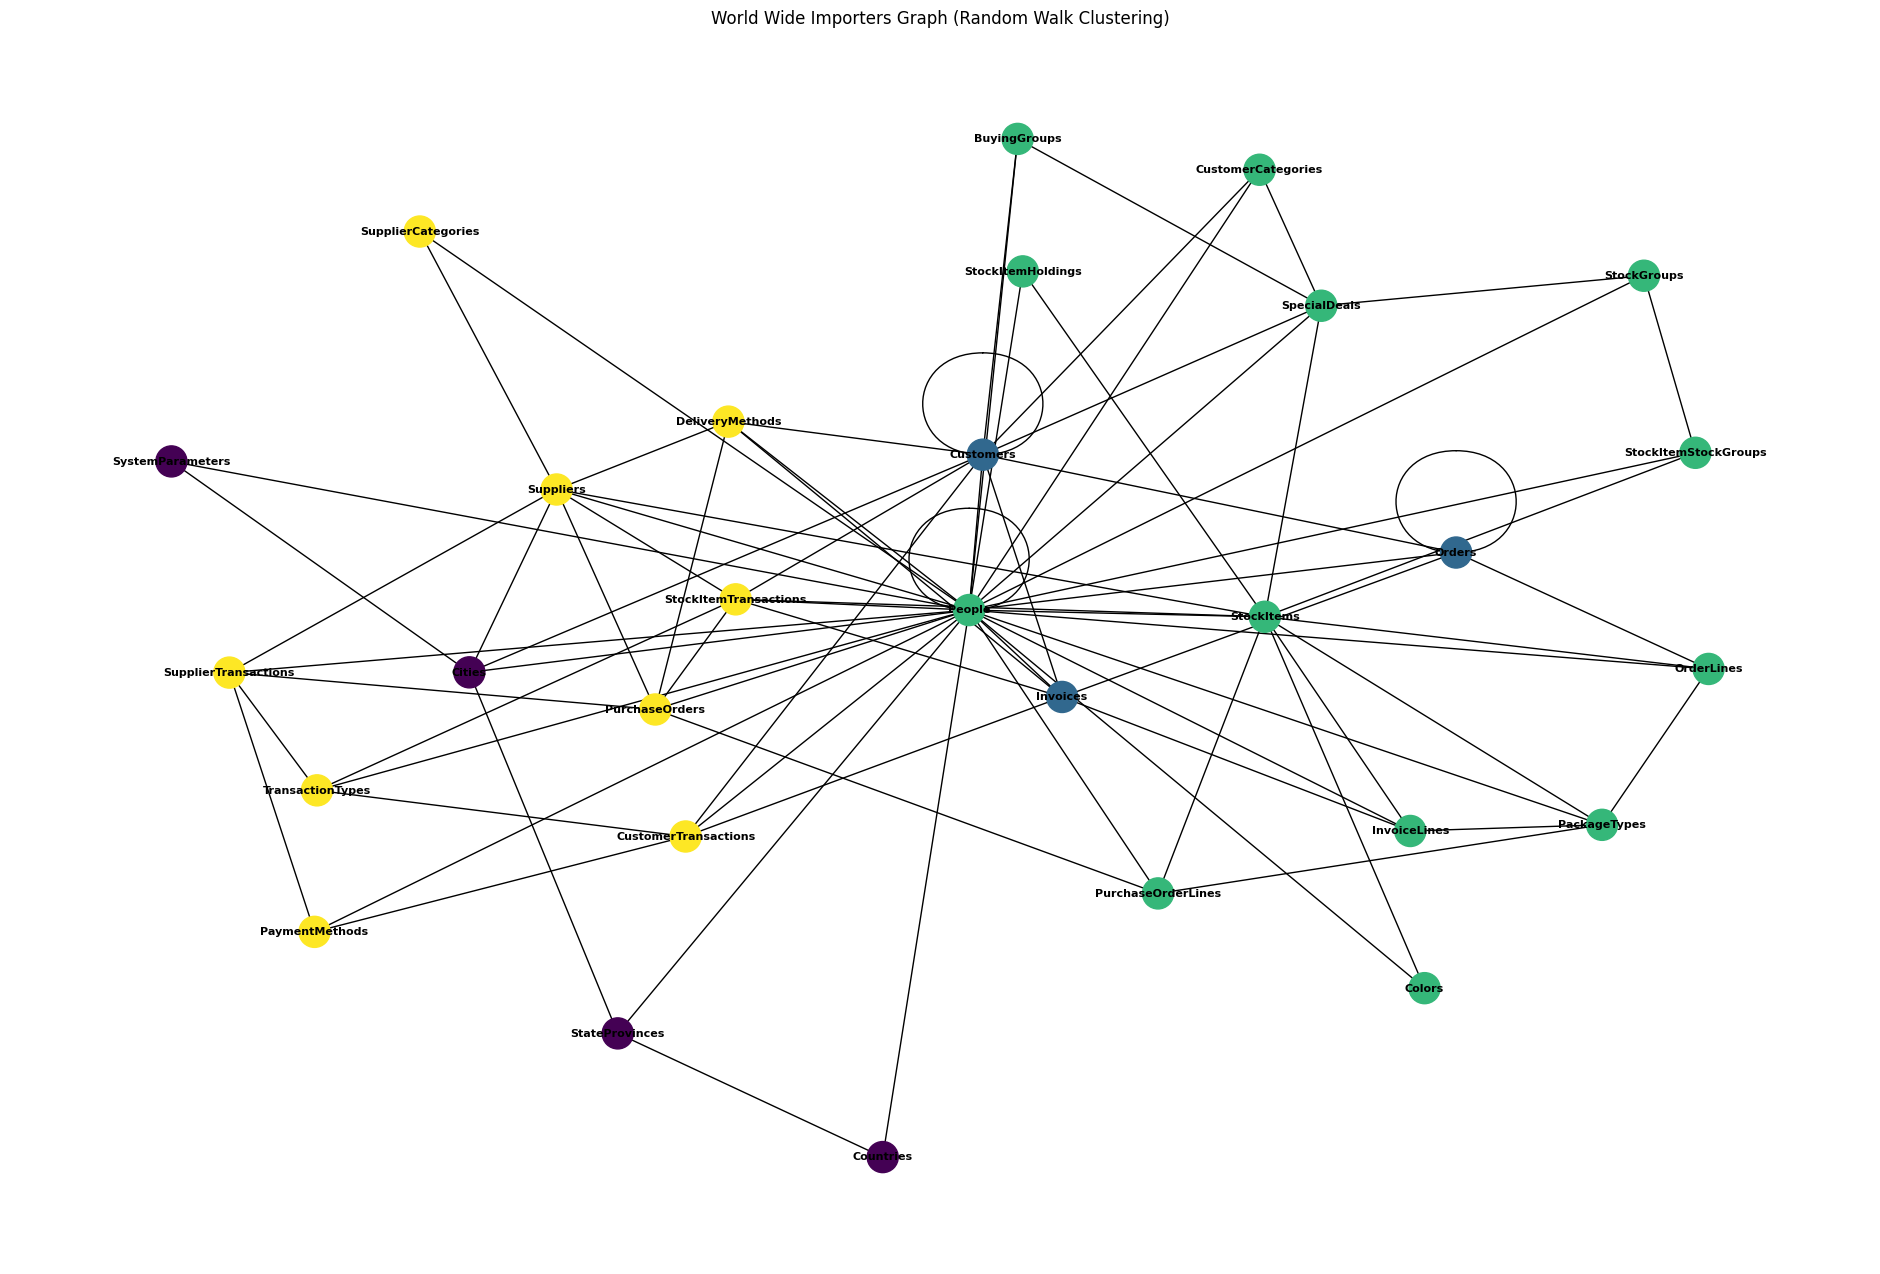

In [9]:
fig, ax = plt.subplots(figsize=(24, 16))
visualize_clusters(G, cluster_labels, "World Wide Importers Graph (Random Walk Clustering)", ax)
plt.show()

In [10]:
def create_cluster_dataframe(G, cluster_labels):
    data = [{'cluster_label': cluster, 'node_label': node.split('.')[1] if '.' in node else node} for node, cluster in zip(G.nodes(), cluster_labels)]
    df = pd.DataFrame(data)
    return df

def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

def calculate_best_matches(subgraph_node_data, table_names_df):
    best_matches = {}
    best_similarity = {}
    match_ratio = {}

    unique_clusters = subgraph_node_data['cluster_label'].unique()
    for cluster in unique_clusters:
        cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
        best_similarity[cluster] = 0.0
        best_matches[cluster] = None

        unique_schemas = table_names_df['table_schema'].unique()

        for schema in unique_schemas:
            schema_df = table_names_df[table_names_df['table_schema'] == schema]
            matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)

            similarity_percentage = (matching / total_cluster) * 100

            if similarity_percentage > best_similarity[cluster]:
                best_similarity[cluster] = similarity_percentage
                best_matches[cluster] = schema

            match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"

    overall_average_similarity = 0
    for cluster, schema in best_matches.items():
        if schema is not None:
            print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
            overall_average_similarity += best_similarity[cluster]
    print(f'Overall Average similarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')

In [11]:
df_clusters = create_cluster_dataframe(G, cluster_labels)
print("World Wide Importers Graph Clustering:")
calculate_best_matches(df_clusters, table_names_df)

World Wide Importers Graph Clustering:
Best match for cluster 3 is schema 'Warehouse' with similarity 46.15% (13/6)
Best match for cluster 1 is schema 'Application' with similarity 100.00% (4/4)
Best match for cluster 4 is schema 'Purchasing' with similarity 44.44% (9/4)
Best match for cluster 2 is schema 'Sales' with similarity 100.00% (3/3)
Overall Average similarity: 72.65%
